In [123]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
import pandas as pd

In [125]:
header = ['userId', 'movieId', 'rating', 'timestamp']
ratings = pd.read_csv('./datos-estructurados-itba-2020/train.csv', sep='\t')
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712
5,1,7,4,875071561
6,1,8,1,875072484
7,1,9,5,878543541
8,1,11,2,875072262
9,1,13,5,875071805


In [126]:
u_unique = ratings.userId.unique()
user2Idx = {o:i+1 for i,o in enumerate(u_unique)}

m_unique = ratings.movieId.unique()
movie2Idx = {o:i+1 for i,o in enumerate(m_unique)}

In [127]:
# Ver parte de los diccionarios
print(dict(list(user2Idx.items())[0:10]))
print(dict(list(movie2Idx.items())[0:10]))

{1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10}
{1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 7: 6, 8: 7, 9: 8, 11: 9, 13: 10}


In [128]:
ratings.userId = ratings.userId.apply(lambda x: user2Idx[x])
ratings.movieId = ratings.movieId.apply(lambda x: movie2Idx[x])

In [129]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [130]:
#IMPORTANTE, agrego yo para que después sea "efectivo" el split entre train,val y test, usar el np para numpy array, sino el de listas hace cualquiera
#  np.random.shuffle(files_clases)

# Shuffle the rows of the DataFrame
shuffled_df = ratings.sample(frac=1, random_state=42)

shuffled_df.head()


,userId,movieId,rating,timestamp
47044,608,948,4,880406168
44295,577,172,5,880474871
74783,891,522,4,883489728
70975,862,658,5,879303668
46645,606,464,5,880925646


In [131]:
from sklearn.model_selection import train_test_split

ratings = shuffled_df
ratings_train, ratings_val = train_test_split(ratings, test_size=0.1)

In [132]:
#n_split = 20000
n_split = 10000
ratings_train = ratings[n_split:]
ratings_val = ratings[:n_split]
len(ratings_train), len(ratings_val)

(70000, 10000)

In [133]:
ratings_train.head()

,userId,movieId,rating,timestamp
73910,886,542,4,876033228
63934,786,268,1,882842762
15252,279,43,3,890780576
25689,405,356,1,885549904
73296,881,1267,2,876539505


In [134]:
n_users = int(ratings.userId.nunique())
n_movies = int(ratings.movieId.nunique())
n_users_train = int(ratings_train.userId.nunique())
n_movies_train = int(ratings_train.movieId.nunique())
print(n_users, n_movies, n_users_train, n_movies_train)

943 1650 943 1627


In [135]:
# Por el embedding que arranca en 1
ratings_train['userId'].max(), ratings_train['movieId'].max()

(943, 1648)

In [136]:
from keras.layers import Embedding, Input, Flatten, Dot
from keras.regularizers import l2
from keras import Model
from keras.constraints import non_neg

In [137]:
n_latent_factors = 20
n_latent_factors = 12

In [138]:
movie_input = Input(shape=[1], name='Item')
# movie_embedding = Embedding(n_movies + 1, n_latent_factors, name='Movie-Embedding', embeddings_constraint=non_neg())(movie_input)
movie_embedding = Embedding(n_movies + 1, n_latent_factors, embeddings_regularizer=l2(0.001),
                            name='Movie-Embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)

user_input = Input(shape=[1],name='User')
user_vec = Flatten(name='FlattenUsers')(Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))
#user_vec = Flatten(name='FlattenUsers')(Embedding(n_users + 1, 
#                                                  n_latent_factors,name='User-Embedding', embeddings_constraint=non_neg())(user_input))

In [139]:
prod = Dot(axes=1, name='DotProduct')([movie_vec, user_vec])
model = Model([user_input, movie_input], prod)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Item (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 User (InputLayer)           [(None, 1)]                  0         []                            
                                                                                                  
 Movie-Embedding (Embedding  (None, 1, 12)                19812     ['Item[0][0]']                
 )                                                                                                
                                                                                                  
 User-Embedding (Embedding)  (None, 1, 12)                11328     ['User[0][0]']          

In [140]:
from keras.optimizers import Adam

In [141]:
from fnn_helper import PlotLosses
plot_losses = PlotLosses(1, None)

In [142]:
import keras.backend as K 
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [143]:
#WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs
import tensorflow as tf
# from tf import tf.keras.optimizers.legacy.Adam

In [144]:
model.compile(tf.keras.optimizers.legacy.Adam(lr=0.001), 'mean_squared_error', metrics=[root_mean_squared_error,'mae', 'accuracy'])
# model.compile(Adam(lr=0.001), 'mean_squared_error', metrics=[root_mean_squared_error])

/Users/hordia/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


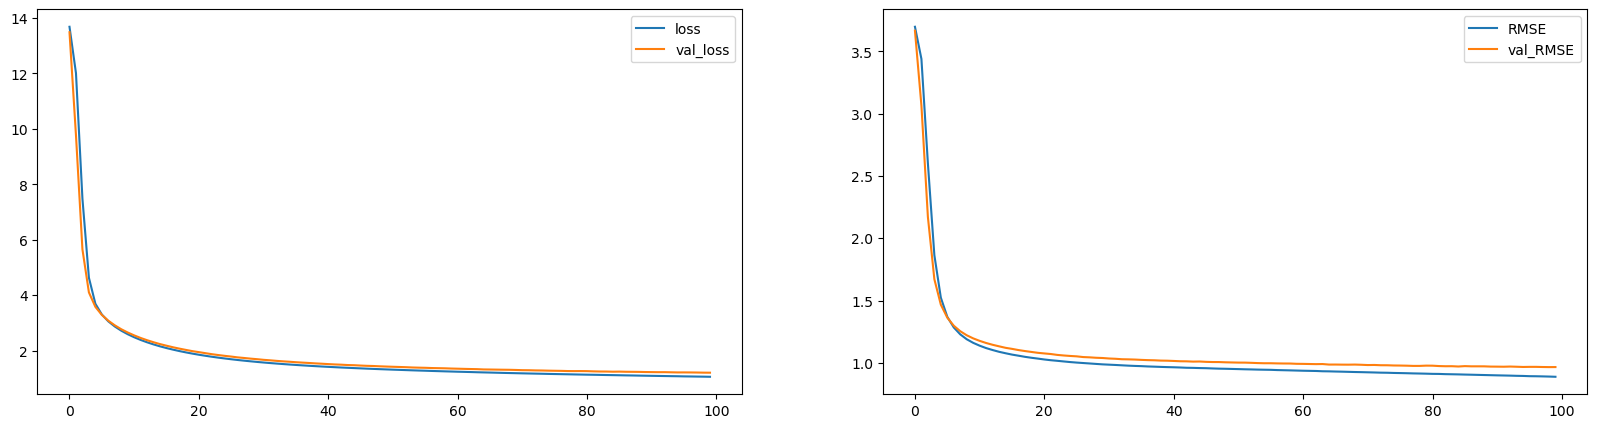

219/219 [==============================] - 2s 11ms/step - loss: 1.0606 - root_mean_squared_error: 0.8883 - mae: 0.7038 - accuracy: 0.0580 - val_loss: 1.2077 - val_root_mean_squared_error: 0.9662 - val_mae: 0.7597 - val_accuracy: 0.0591


In [145]:
history = model.fit([ratings_train.userId, ratings_train.movieId], 
                    ratings_train.rating, 
                    batch_size=320,
                    validation_data=([ratings_val.userId, ratings_val.movieId], ratings_val.rating), 
                    epochs=100, 
                    callbacks = [plot_losses],
                    verbose=1)

188/188 [==============================] - 2s 12ms/step - loss: 0.9888 - root_mean_squared_error: 0.8409 - mae: 0.6650 - accuracy: 0.0583 - val_loss: 1.1854 - val_root_mean_squared_error: 0.9503 - val_mae: 0.7467 - val_accuracy: 0.0576

In [48]:
model.metrics_names

['loss', 'root_mean_squared_error', 'mae', 'accuracy']

In [49]:
model.evaluate([ratings_val.userId, ratings_val.movieId], ratings_val.rating)

625/625 [==============================] - 4s 7ms/step - loss: 1.1854 - root_mean_squared_error: 0.9413 - mae: 0.7467 - accuracy: 0.0576


[1.1854076385498047,
 0.9413222670555115,
 0.7467437982559204,
 0.05764999985694885]

In [50]:
model.evaluate([ratings_train.userId, ratings_train.movieId], ratings_train.rating)

1875/1875 [==============================] - 13s 7ms/step - loss: 0.9554 - root_mean_squared_error: 0.8148 - mae: 0.6481 - accuracy: 0.0585


[0.9554201364517212,
 0.8147689700126648,
 0.6481419205665588,
 0.058533333241939545]

In [51]:
data = {'userId': [1, 1, 1, 2, 2],
        'movieId': [5, 6, 7, 5, 67]}
df = pd.DataFrame(data)



In [58]:

df_out = model.predict([df.userId, df.movieId])


1/1 [==============================] - 0s 71ms/step


In [95]:
pd.DataFrame(df_out).head()

,0
0,2.872643
1,4.285511
2,4.419296
3,3.125026
4,3.796313


In [98]:
test_data = pd.read_csv('./datos-estructurados-itba-2020/test.csv', sep=',') # final test
test_data.head()

,Id,userId,movieId,rating
0,0,1,6,3
1,1,1,10,3
2,2,1,12,3
3,3,1,14,2
4,4,1,17,4


In [99]:
#entonces las que tengo que predecir
df_tmp = test_data[test_data['rating'] == 0]

df_predicted = pd.DataFrame(
    model.predict([df_tmp.userId, df_tmp.movieId])
)

127/127 [==============================] - 0s 2ms/step


In [100]:
df_predicted.head()

,0
0,3.579654
1,3.474125
2,3.732467
3,4.076623
4,4.303087


In [101]:
# decimal_places = 0
# df['rating'] = df['rating'].round(decimal_places)

# df['rating'] = df['rating'].round().as_type(int)

In [103]:
def estimate_rates(user, movie):
    data = {'userId': [user],
        'movieId': [movie]}
    df = pd.DataFrame(data)
    df_out = model.predict([df.userId, df.movieId])
    # print(user, movie)
    # print(df_out[0][0])
    return df_out[0][0]

In [104]:
import numpy as np

In [111]:
min_c=1 #mínima calificación posible
max_c=5 #máxima
print( np.clip( np.round(0.2),min_c,max_c) )
print( np.clip( np.round(1.3),min_c,max_c) )
print( np.clip( np.round(1.7),min_c,max_c) )
print( np.clip( np.round(5.2),min_c,max_c) )
print( np.clip( np.round(4.2),min_c,max_c) )

1.0
1.0
2.0
5.0
4.0


In [112]:
# esto se tiene que poder resolver aplicando una función tipo lambda a test_data[test_data['rating'] == 0] 
# TODO: hacerlo más eficiente
for index, row in test_data.iterrows():
    # print(index, row['rating'])
    if row['rating']==0:
        print(index)
        # row['rating'] = 4 # predicted 
        user = row['userId']
        movie_item = row['movieId']
        prediction = estimate_rates(user,movie_item)
        # print(prediction)
        #warning si redondeo y da 0.3, deberia ser 1 que es el mínimo por eso también clippeo
        row['rating'] = np.clip( np.round(prediction),min_c,max_c) # redondeo porque los ratings son de 1 al 5 a

58
1/1 [==============================] - 0s 17ms/step
919
1/1 [==============================] - 0s 13ms/step
1210
1/1 [==============================] - 0s 13ms/step
1355
1/1 [==============================] - 0s 12ms/step
1502
1/1 [==============================] - 0s 11ms/step
1508
1/1 [==============================] - 0s 13ms/step
1514
1/1 [==============================] - 0s 11ms/step
1523
1/1 [==============================] - 0s 11ms/step
1524
1/1 [==============================] - 0s 12ms/step
1529
1/1 [==============================] - 0s 12ms/step
1531
1/1 [==============================] - 0s 12ms/step
1534
1/1 [==============================] - 0s 11ms/step
1539
1/1 [==============================] - 0s 11ms/step
1542
1/1 [==============================] - 0s 11ms/step
1551
1/1 [==============================] - 0s 11ms/step
1552
1/1 [==============================] - 0s 11ms/step
1565
1/1 [==============================] - 0s 11ms/step
1570
1/1 [========================

In [113]:
test_data[test_data['rating'] == 0].head()
len( test_data[test_data['rating'] == 0] )

0

In [114]:
# df['rating'] = df['rating'].round().as_type(int)


In [115]:
test_data.to_csv('test-with-predicted-keras.csv', index=False) # ya tiene una columna índice, no agregar otra

In [116]:
test_data

,Id,userId,movieId,rating
0,0,1,6,3
1,1,1,10,3
2,2,1,12,3
3,3,1,14,2
4,4,1,17,4
...,...,...,...,...
19995,19995,458,648,3
19996,19996,458,1101,3
19997,19997,459,934,2
19998,19998,460,10,3
